# Automatyzacja pracy z danymi przestrzennymi w Pythonie i GeoPandas

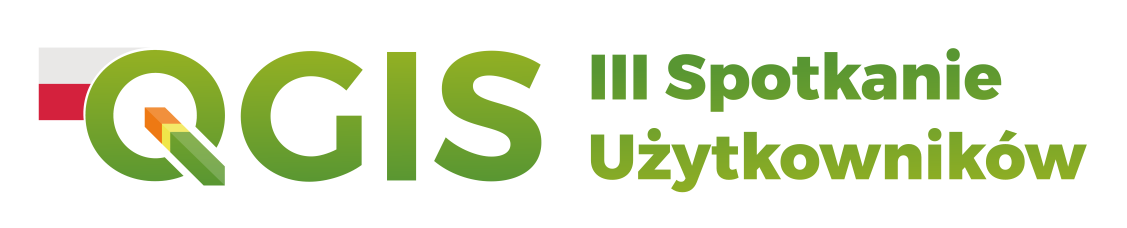

## Meta


- **Prowadzący**: Szymon Moliński (Digitree SA)
- **Data**: 2024-06-26
- **Miejsce**: Poznań
- **Część**: 2

## Wprowadzenie do GeoPandas i obiektów typu `GeoSeries` i `GeoDataFrame`

W tym przykładzie wprowadzimy koncept `geometrii` jako specjalnej kolumny w ramkach danych. Zobaczymy, jak doprowadzić bazową ramkę danych `pandas`-a do obiektu type `GeoDataFrame`.

Wykorzystamy poprzedni zbiór cen najmu krótkoterminowego AirBnB w Nowym Jorku: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FPATH = "/content/drive/MyDrive/geopandas-workshops/AB_NYC_2019.csv"

In [ ]:
df = pd.read_csv(FPATH, index_col='id')

In [ ]:
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Geometria

W tej chwili zbiór nie posiada obiektów geometrycznych a szerokość i długość geograficzną zapisane jako `latitude` i `longitude`. Współrzędne w tej formie:

- mają nieokreśloną projekcję
- nie można ich stosować w zadaniach analizy przestrzennej

Kolumny `latitude` i `longitude` reprezentują punkty w przestrzeni. Dodatkowo, kolumny `neighbourhood_group` i `neighbourhood` też niosą za sobą informację przestrzenną (gdybyśmy posiadali dostęp do polygonów opisujących dzielnice, moglibyśmy dołączyć takie dane do ramki).

Załóżmy, że naszym zadaniem jest obliczenie odległości między tymi punktami a przesuwającymi się po mapie taksówkami tylko jeśli te taksówki znajdują się w tej samej dzielnicy co apartament. Jest to typowe zadanie analizy przestrzennej. Można je łatwo wykonać, jeśli korzysta się z silników obsługujących obliczenia przestrzenne. Takim narzędziem jest `GeoPandas`.

Zacznijmy więc działać na danych przestrzennych. Jak? Zróbmy je danymi przestrzennymi tworząc kolumnę z geometryczną reprezentacją punktów, ustawmy również projekcję danych.

Podstawowe geometrie to:

- `Point`
- `Line`
- `Polygon`

a zaimplementowane są w paczce `shapely`, która jest *pod spodem* `GeoPandas`.

In [ ]:
from geopandas import points_from_xy

In [ ]:
points = points_from_xy(x=df['longitude'], y=df['latitude'], crs="EPSG:4326")

In [ ]:
points

<GeometryArray>
[<POINT (-73.972 40.647)>, <POINT (-73.984 40.754)>, <POINT (-73.942 40.809)>,
  <POINT (-73.96 40.685)>, <POINT (-73.944 40.799)>, <POINT (-73.975 40.748)>,
 <POINT (-73.956 40.687)>, <POINT (-73.985 40.765)>, <POINT (-73.967 40.802)>,
  <POINT (-73.99 40.713)>,
 ...
 <POINT (-73.936 40.796)>, <POINT (-73.967 40.756)>, <POINT (-73.942 40.712)>,
 <POINT (-73.992 40.764)>, <POINT (-73.808 40.691)>,  <POINT (-73.95 40.679)>,
 <POINT (-73.933 40.702)>, <POINT (-73.949 40.815)>, <POINT (-73.991 40.758)>,
 <POINT (-73.989 40.764)>]
Length: 48895, dtype: geometry

In [ ]:
type(points)

geopandas.array.GeometryArray

## `GeoSeries`

In [ ]:
geometry = gpd.GeoSeries(points)

<Axes: >

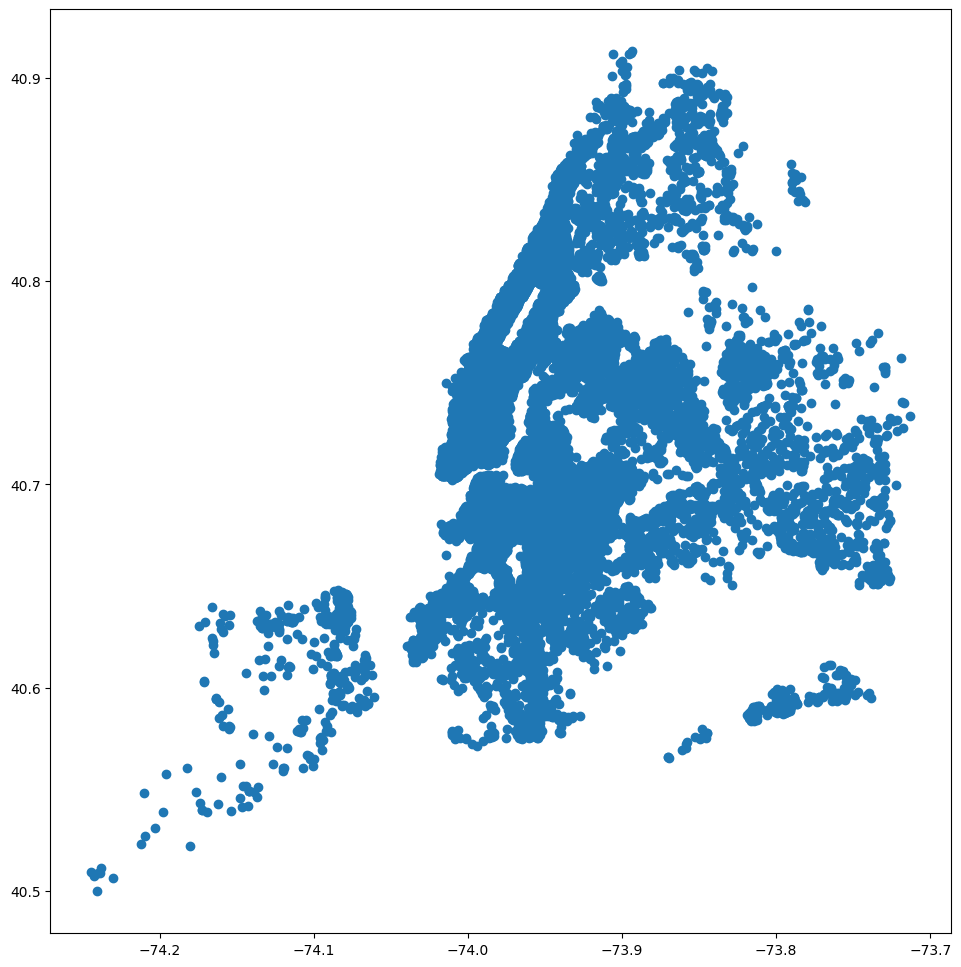

In [ ]:
geometry.plot(figsize=(12, 12))

In [ ]:
geometry.geom_type

0        Point
1        Point
2        Point
3        Point
4        Point
         ...  
48890    Point
48891    Point
48892    Point
48893    Point
48894    Point
Length: 48895, dtype: object

In [ ]:
print(f'Typy geometrii w danych to: {geometry.geom_type.unique()}, a typ obiektu to: {geometry.dtype}')

Typy geometrii w danych to: ['Point'], a typ obiektu to: geometry


In [ ]:
geometry.total_bounds

array([-74.24442,  40.49979, -73.71299,  40.91306])

In [ ]:
from typing import Union
from shapely import Polygon


def points_to_bounding_box(points: Union[gpd.GeoSeries, gpd.GeoDataFrame]):
    """
    Function transform a set of points into a Polygon with bounding box.

    Parameters
    ----------
    points : gpd.GeoSeries

    Returns
    -------
    bounding_box : Polygon
    """
    bounds = points.total_bounds

    x_min, y_min, x_max, y_max = bounds

    polygon_tuples = [
        (x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)
    ]

    polygon = Polygon(polygon_tuples)
    return polygon


poly = points_to_bounding_box(geometry)
poly_frame = gpd.GeoSeries(poly, crs=geometry.crs)

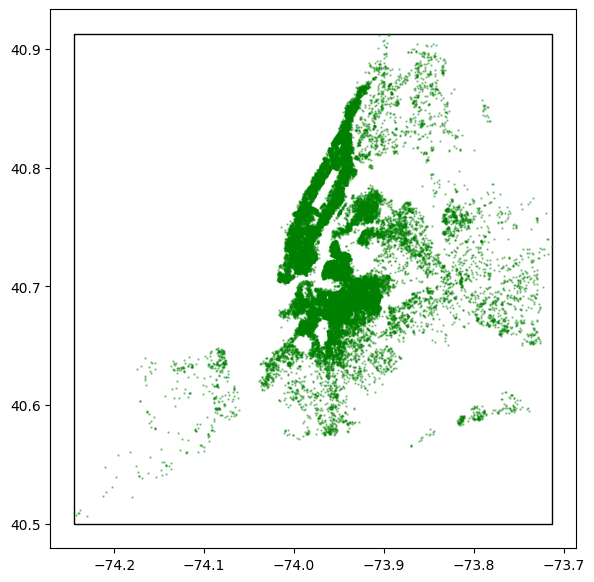

In [ ]:
fs = (7, 7)

base = poly_frame.plot(color='white', edgecolor='black', figsize=fs)
geometry.plot(ax=base, color='green', markersize=0.5, alpha=0.4);

In [ ]:
geometry.explore()

ImportError: The 'folium', 'matplotlib' and 'mapclassify' packages are required for 'explore()'. You can install them using 'conda install -c conda-forge folium matplotlib mapclassify' or 'pip install folium matplotlib mapclassify'.

In [ ]:
!pip install folium matplotlib mapclassify

In [ ]:
# geometry.explore()

In [ ]:
# Usuwamy zawartość komórki z mapą u góry żeby nie obciążać notatnika

## `GeoDataFrame`

Wczytajmy teraz właściwy plik z danymi przestrzennymi - granice dystryktów w metropolii Nowego Jorku. Plik ten jest spakowany w archiwum `zip` pod nazwą `nybbwi_20d.zip`. Możemy rozpakować archiwum i wczytać plik `shp` albo możemy odczytać dane prosto z archiwum.

In [ ]:
ny_path = "/content/drive/MyDrive/geopandas-workshops/nybbwi_20d.zip"
zip_ny_path = "zip://" + ny_path + "!" + "nybbwi_20d/nybbwi.shp"
gdf = gpd.read_file(zip_ny_path)

<Axes: >

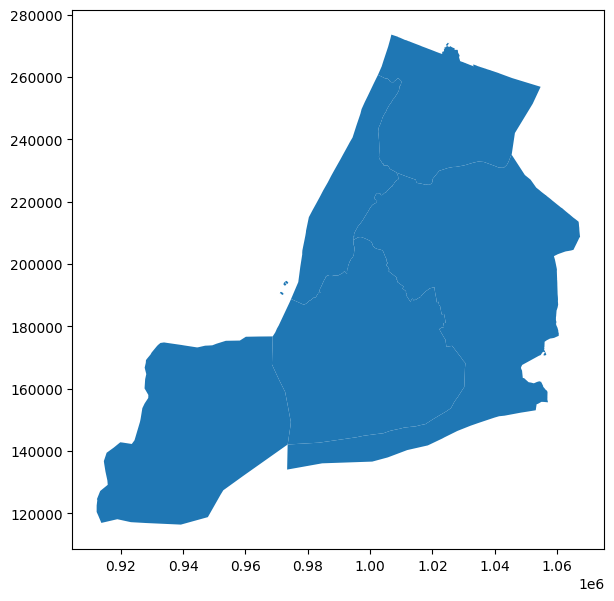

In [ ]:
gdf.plot(figsize=fs)

In [ ]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BoroCode    5 non-null      int64   
 1   BoroName    5 non-null      object  
 2   Shape_Leng  5 non-null      float64 
 3   Shape_Area  5 non-null      float64 
 4   geometry    5 non-null      geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 328.0+ bytes


In [ ]:
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich